# sourcing the data

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import json 

from utils import load_egraph_data, get_egraph_from_dir, get_dataframes, parse_stop, load_sledge_data, prepare_step_data
plt.style.use('./latex_style.mplstyle')


data_dir = "../../data/"

egraph_data = get_egraph_from_dir(data_dir)

dataframes = get_dataframes(egraph_data)

egraph = {}

for name, df in dataframes.items():
    if 'alive' in name:
        if 'alive' in egraph:
            egraph['alive'] = pd.concat([egraph['alive'], df])
        else:
            egraph['alive'] = df
    else:
        egraph[name]=df

egraph['alive']

,iterations,stop_reason,egraph_nodes,egraph_classes,memo_size,rebuilds,total_time,search_time,apply_time,rebuild_time,memory,runtime
Select_1100,1,Equivalent,6,5,6,0,0.0,0.0,0.0,0.0,0.35,0.335323
Select_1105,1,Equivalent,6,5,6,0,0.0,0.0,0.0,0.0,0.35,0.332731
muldivrem_152,3,Equivalent,55,31,64,6,0.000086,0.000029,0.000051,0.000005,0.68,0.486089
AddSub_1539_2,3,Equivalent,81,45,86,2,0.000113,0.000034,0.000071,0.000007,0.76,0.563955
muldivrem_290_292,3,Equivalent,65,40,82,12,0.000117,0.000037,0.000071,0.000008,0.84,0.637388
...,...,...,...,...,...,...,...,...,...,...,...,...
InstCombineShift582,4,Saturated,71,46,74,1,0.000277,0.000108,0.000162,0.000006,0.69,0.655284
InstCombineShift279,4,Saturated,79,48,82,1,0.000459,0.000159,0.000289,0.000011,0.78,0.939146
InstCombineShift476,6,Saturated,137,75,159,10,0.000965,0.000332,0.000613,0.00002,1.51,1.513425
InstCombineShift440,11,Timeout,157666,70646,197008,15251,72.536716,72.216971,0.252594,0.067139,6763.69,72860.790439


In [2]:
sledge_raw = {}

data_dir = '../../data/'

for bench in os.listdir(data_dir):
    lemma_data = load_sledge_data(f"{data_dir}{bench}/lemma/parsed.json")
    no_lemma_data = load_sledge_data(f"{data_dir}{bench}/no_lemma/parsed.json")
    assert len(lemma_data) == len(dataframes[bench])
    assert len(no_lemma_data) == len(dataframes[bench])
    sledge_raw[bench] = pd.DataFrame({
        'lemma':lemma_data,
        'no_lemma':no_lemma_data
    })

sledge = {}
for test, df in sledge_raw.items():
    if 'alive' in test:
        if 'alive' in sledge:
            sledge['alive'] = pd.concat([sledge['alive'], df])
        else:
            sledge['alive'] = df
    else:
        sledge[name]=df

print(sledge['alive'].to_string())

                        lemma  no_lemma
AddSub_1614             197.0    5443.0
muldivrem_152           416.0       NaN
Select_1105             222.0     182.0
InstCombineShift497d      NaN       NaN
AddSub_1164              54.0    5912.0
AddSub_1574            1574.0       NaN
muldivrem_239          4674.0       NaN
AddSub_1176              93.0    5912.0
Select_1100             244.0     193.0
AddSub_1539_2           477.0     134.0
muldivrem_290_292       629.0       NaN
muldivrem_229            89.0       NaN
AddSub_1165              49.0   12258.0
AddSub_1619             144.0       NaN
AndOrXor_2063          7208.0       NaN
AndOrXor_2429           334.0       NaN
AndOrXor_2284           727.0       NaN
AndOrXor_2367           301.0       NaN
AndOrXor_1247           988.0       NaN
AndOrXor_1288           286.0       NaN
AndOrXor_144            510.0       NaN
AndOrXor_2263             NaN       NaN
AndOrXor_2658           455.0       NaN
AndOrXor_2595           630.0       NaN


/tmp/ipykernel_3367739/609628669.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sledge['alive'] = pd.concat([sledge['alive'], df])


In [3]:
artifact_dir = '../../../alive_bench/processed_artifact'

toward_data = pd.DataFrame()

for file in os.listdir(artifact_dir):
    name = file.removesuffix('.json')
    print(file, name)
    with open(os.path.join(artifact_dir,file), 'r') as f:
        data = json.load(f)
    
    data = {k.replace(':', '_').replace('-', '_'):v for (k,v) in data.items()}
    
    # using combined since it was the most effective method out of all of them
    new_data = {k: data[k]['combined']['time'] *1000 if data[k]['combined']['status'] == 'unsat' else None for k in data }
    toward_data[name] = new_data

toward_data['num_solved'] = toward_data.apply(lambda x: sum([int(not math.isnan(t)) for t in x]), axis=1)
toward_data = toward_data.where(toward_data['num_solved'] > 0).sort_values(by='num_solved', ascending=True).drop('num_solved', axis=1)
print(toward_data.to_string())

cvc4_tplanes.json cvc4_tplanes
cvc4_tplanes_saturate_no_e_matching.json cvc4_tplanes_saturate_no_e_matching
vampire.json vampire
z3_default.json z3_default
                      cvc4_tplanes  cvc4_tplanes_saturate_no_e_matching   vampire  z3_default
AndOrXor_298                   NaN                              50170.0       NaN         NaN
AndOrXor_1864                  NaN                               8380.0       NaN         NaN
Select_510                     NaN                              41470.0       NaN         NaN
Select_741                     NaN                               4380.0       NaN         NaN
muldivrem_290_292           1060.0                                  NaN       NaN         NaN
muldivrem_876                  NaN                              13080.0       NaN         NaN
AddSub_1604                    NaN                              50530.0       NaN         NaN
AddSub_1599                    NaN                              62330.0       NaN         Na

In [4]:
def plot_cactus(ax, dataframe, timeout = None, pltopts = None):
    num_problems = len(dataframe)
    
    ax.axhline(num_problems, label=f'Number of problems: {num_problems}',color='blue')
    if timeout:
        ax.axvline(timeout, label=f'Timeout: {timeout/1000:.3g} Seconds', color='grey', linestyle='--')

    for name, values in dataframe.items():
        solved = values.dropna()
        x, y = prepare_step_data(solved.to_list())
        
        if timeout and x[-1] < timeout:
            y.append(y[-1])
            x.append(timeout)
        
        line_opts = pltopts.get(name, {}) if pltopts else {}
        
        ax.plot(x, y, drawstyle="steps-post", label=f"{name}: {len(solved)} (${100*len(solved)/num_problems:.0f}\\%$) ", **line_opts)

    ax.set_xlabel('Runtime (ms)')
    ax.set_ylabel('Number of solved problems')
    ax.set_xscale('log')
    
def combine_results(x):
    vals_as_list = x.dropna().to_list()
    if vals_as_list != []:
        return min(x.dropna().to_list()) 
    else:
        return None


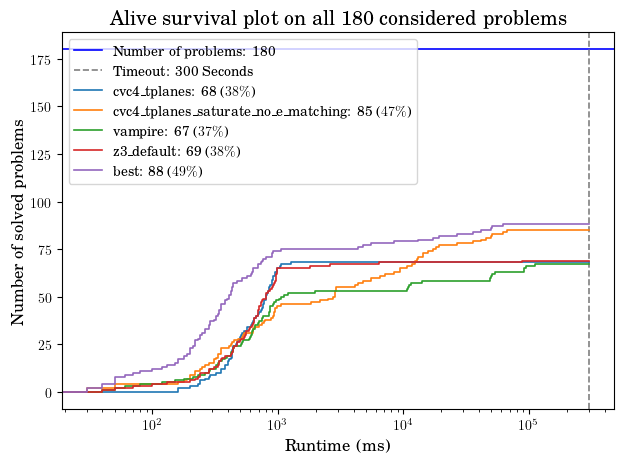

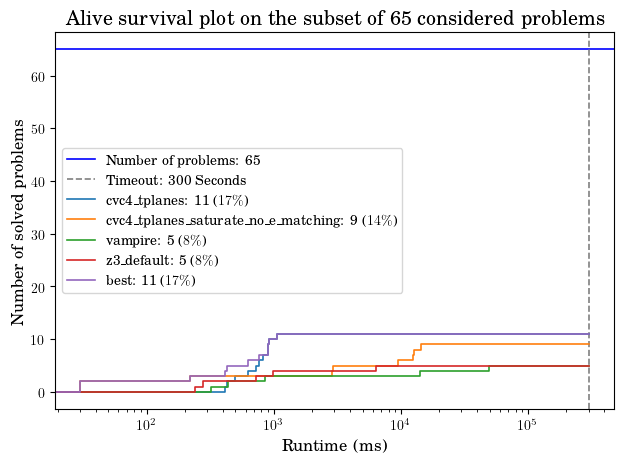

In [5]:
fig_dest = '../../out/artifact/img/'
os.makedirs(fig_dest, exist_ok=True)


fig, ax = plt.subplots()

toward_data['best'] = toward_data.apply(combine_results, axis=1)

plot_cactus(ax, toward_data, 300000)
ax.legend(loc='best')
ax.set_title('Alive survival plot on all 180 considered problems')
plt.tight_layout()
plt.savefig(f"{fig_dest}all_problem.pdf")
plt.show()

fig, ax = plt.subplots()

filtered = toward_data.filter(items=sledge['alive'].index.to_list(), axis=0)
 
plot_cactus(ax, filtered,  300000)
ax.legend(loc='best')
ax.set_title('Alive survival plot on the subset of 65 considered problems')
plt.tight_layout()
plt.savefig(f"{fig_dest}sub65_problem.pdf")
plt.show()

# ROVER

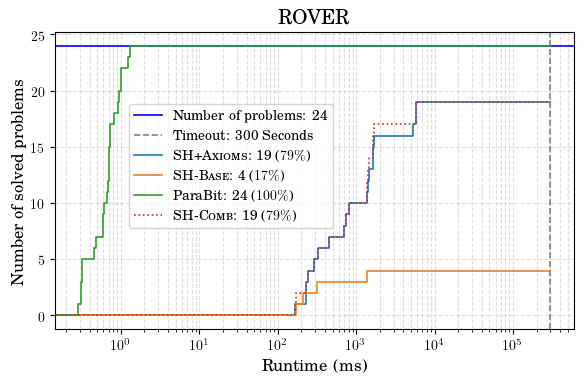

In [6]:
fig_dest = '../../out/eval/img/'
os.makedirs(fig_dest, exist_ok=True)

data = sledge['rover'].copy()
data['ParaBit'] = egraph['rover']['runtime'].copy()

data['\\textsc{SH-Comb}'] = data[['lemma', 'no_lemma']].apply(combine_results, axis=1)
# data['SH + paraBit'] = data[['SH combined', 'parabit']].apply(combine_results, axis=1)

fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('ROVER')
plot_cactus(ax, data.rename(columns={'lemma':'\\textsc{SH+Axioms}', 'no_lemma':'\\textsc{SH-Base}', 'SH combined':'\\textsc{SH-Comb}'}), 5*60*1000, {'\\textsc{SH-Comb}':{'linestyle':'dotted'}})

# plot_cactus(ax, data, 5*60*1000)
ax.grid(which='both', alpha=0.4, linestyle='dashed')

ax.legend(loc='center right',bbox_to_anchor=(0.55, 0.55))

plt.tight_layout()
plt.savefig(f"{fig_dest}rover_survival.pdf")
plt.show()

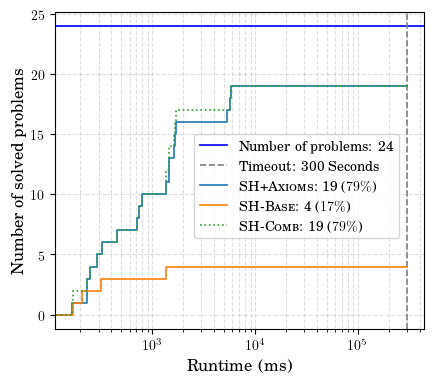

In [7]:
fig_dest = '../../out/eval/img/'
os.makedirs(fig_dest, exist_ok=True)

data = sledge['rover'].copy()
data['SH combined'] = data[['lemma', 'no_lemma']].apply(combine_results, axis=1)

# data['parabit'] = egraph['rover']['runtime']

# data['SH combined'] = data[['lemma', 'no_lemma']].apply(combine_results, axis=1)
# data['SH + paraBit'] = data[['SH combined', 'parabit']].apply(combine_results, axis=1)

fig, ax = plt.subplots(figsize=(4.5,4))
# ax.set_title('ROVER')
plot_cactus(ax, data.rename(columns={'lemma':'\\textsc{SH+Axioms}', 'no_lemma':'\\textsc{SH-Base}', 'SH combined':'\\textsc{SH-Comb}'}), 5*60*1000, {'\\textsc{SH-Comb}':{'linestyle':'dotted'}})
ax.legend(loc='center right',bbox_to_anchor=(0.95, 0.45))
ax.grid(which='both', alpha=0.4, linestyle='dashed')
plt.tight_layout()
plt.savefig(f"{fig_dest}rover_q1.pdf")
plt.show()

# Alive

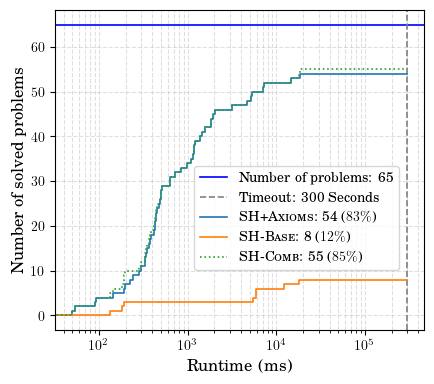

In [8]:
fig_dest = '../../out/eval/img/'
os.makedirs(fig_dest, exist_ok=True)

data = sledge['alive'].copy()
data['SH combined'] = data[['lemma', 'no_lemma']].apply(combine_results, axis=1)

# data['alive_bw_lemma'] = sledge_raw['alive_bitwise']['lemma']
# data['parabit'] = egraph['rover']['runtime']

# data['SH combined'] = data[['lemma', 'no_lemma']].apply(combine_results, axis=1)
# data['SH + paraBit'] = data[['SH combined', 'parabit']].apply(combine_results, axis=1)

fig, ax = plt.subplots(figsize=(4.5,4))
# ax.set_title('Alive')
plot_cactus(ax, data.rename(columns={'lemma':'\\textsc{SH+Axioms}', 'no_lemma':'\\textsc{SH-Base}', 'SH combined':'\\textsc{SH-Comb}'}), 5*60*1000, {'\\textsc{SH-Comb}':{'linestyle':'dotted'}})
ax.legend(loc='center right', bbox_to_anchor=(0.95, 0.35))
ax.grid(which='both', alpha=0.4, linestyle='dashed')

plt.tight_layout()
plt.savefig(f"{fig_dest}alive_q1.pdf")
plt.show()

In [9]:
records = []
dest_dir = '../../out/eval/'
os.makedirs(fig_dest, exist_ok=True)

for key, df in sledge_raw.items():
    total = len(df)
    lemma_count = df['lemma'].notnull().sum()
    no_lemma_count = df['no_lemma'].notnull().sum()
    comb_count = df.apply(combine_results, axis=1).notnull().sum()
    records.append({
        'key': key,
        'total': total,
        'lemma_non_null': lemma_count,
        'no_lemma_non_null': no_lemma_count,
        'comb': comb_count
    })

summary_df = pd.DataFrame.from_records(records).set_index('key')
with open(f"{dest_dir}table_q1.tex", 'w') as f:
    f.write(summary_df.to_latex())
print(summary_df)

               total  lemma_non_null  no_lemma_non_null  comb
key                                                          
alive_arith       14              13                  7    13
alive_bitwise     36              34                  0    34
alive_mixed       15               7                  1     8
rover             24              19                  4    19


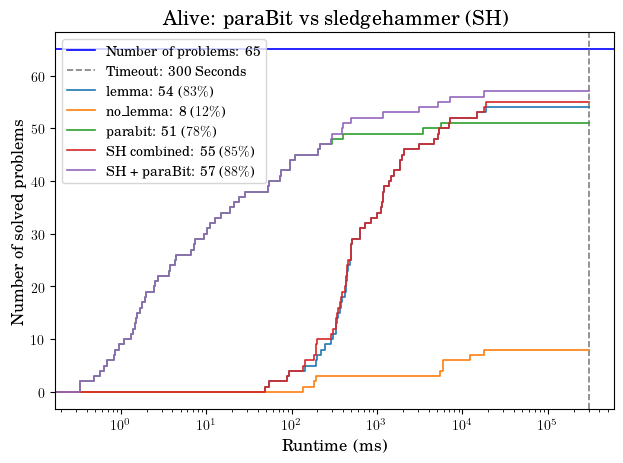

In [10]:
fig_dest = '../../out/eval/img/'
os.makedirs(fig_dest, exist_ok=True)

data = sledge['alive'].copy()
data['parabit'] = egraph['alive']['runtime'].where(egraph['alive']['stop_reason'] == 'Equivalent')

data['SH combined'] = data[['lemma', 'no_lemma']].apply(combine_results, axis=1)
data['SH + paraBit'] = data[['SH combined', 'parabit']].apply(combine_results, axis=1)
# data['combine'] = data.apply(lambda x: print(x.dropna().to_list()), axis=1)


fig, ax = plt.subplots()
ax.set_title('Alive: paraBit vs sledgehammer (SH)')

TIMEOUT = 5*60*1000

plot_cactus(ax, data, TIMEOUT)
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f"{fig_dest}alive_sh_survival.pdf")
plt.show()



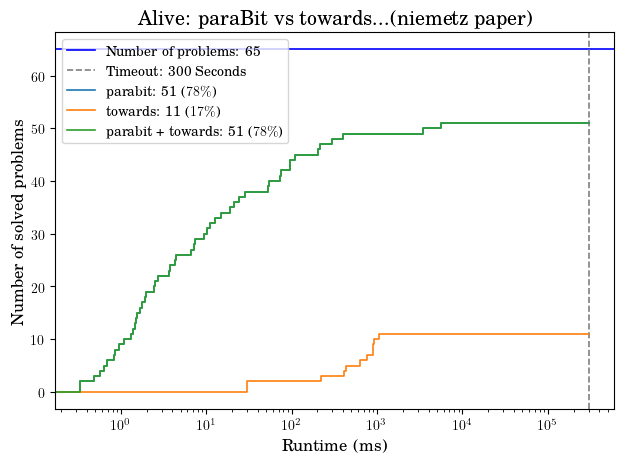

In [11]:
towards_comp = filtered.copy()
towards_comp['parabit'] = egraph['alive']['runtime'].where(egraph['alive']['stop_reason'] == 'Equivalent')

towards_comp['parabit + towards'] = towards_comp[['parabit', 'best']].apply(combine_results, axis=1)


fig, ax = plt.subplots()
ax.set_title('Alive: paraBit vs towards...(niemetz paper)')

TIMEOUT = 5*60*1000

plot_cactus(ax, towards_comp[['parabit', 'best', 'parabit + towards']].rename(columns={'best':'towards'}), TIMEOUT)
ax.legend()
plt.tight_layout()
plt.savefig(f"{fig_dest}alive_towards_survival.pdf")
plt.show()

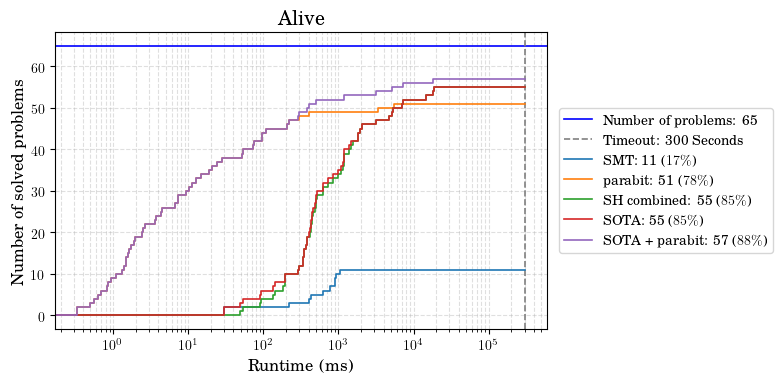

In [19]:
data['SMT'] = filtered['best']
data['SOTA'] = data[['SMT', 'SH combined']].apply(combine_results, axis=1)
data['SOTA + parabit'] = data[['SOTA', 'parabit']].apply(combine_results, axis=1)


fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('Alive')

TIMEOUT = 5*60*1000

plot_cactus(ax, data[['SMT', 'parabit', 'SH combined', 'SOTA', 'SOTA + parabit']], TIMEOUT)
ax.grid(which='both', alpha=0.4, linestyle='dashed')

ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.savefig(f"{fig_dest}alive_sota_survival.pdf")
plt.show()

## Alive per subset breakdown

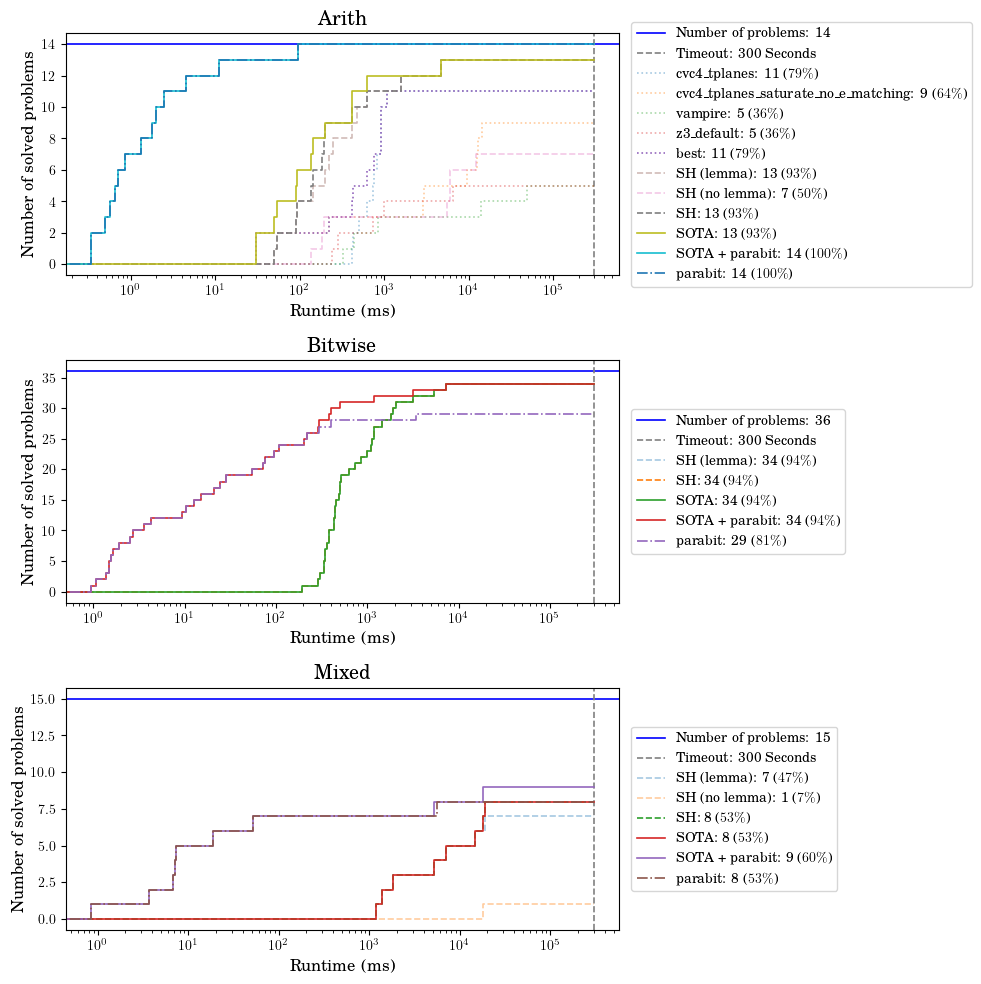

In [13]:
towards_bytype = {}

fig, axs = plt.subplots(3, 1, figsize=(10,10))

for i, bench in enumerate(['alive_arith', 'alive_bitwise', 'alive_mixed']):
    ax = axs[i]
    
    benchdf = filtered.filter(items=dataframes[bench].index.to_list(), axis=0)
    # print(towards_bytype[bench])
    opts = {name: {"alpha":0.4, "linestyle":"dotted"} for name in benchdf.columns}
    opts['best'] = {"linestyle":'dotted'}
    
    benchdf['SH (lemma)'] = data['lemma']
    benchdf['SH (no lemma)'] = data['no_lemma']
    benchdf['SH'] = data['SH combined']
    opts['SH (lemma)'] = {"linestyle":"dashed","alpha":0.4}
    opts['SH (no lemma)'] = {"linestyle":"dashed","alpha":0.4}
    opts['SH'] = {"linestyle":"dashed"}
    benchdf['SOTA'] = data['SOTA']
    benchdf['SOTA + parabit'] = data['SOTA + parabit']
    benchdf['parabit'] = data['parabit']
    opts['parabit'] = {"linestyle":"dashdot"}
    
    for col in benchdf:
        if benchdf[col].dropna().to_list() == []:
            benchdf.drop(col,axis=1, inplace=True)
    
    ax.set_title(bench.replace('alive_', '').capitalize())
    plot_cactus(ax, benchdf, 300000, opts)
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
    
    
plt.tight_layout()
plt.savefig(f"{fig_dest}alive_perbench_survival.pdf")
plt.show()

# Tables

In [14]:
records = []
dest_dir = '../../out/eval/'
os.makedirs(fig_dest, exist_ok=True)


for (key, df), (key2, edf) in zip(sledge_raw.items(), dataframes.items()):
    print(key, key2)
    # print(df, edf)
    assert key == key2
    total = len(df)
    assert total == len(edf), print(total, len(edf))

    sh_comb = df.apply(combine_results, axis=1)
    parabit = edf['runtime'].where(edf['stop_reason'] == 'Equivalent')
    # print( parabit.notnull())
    # print( sh_comb.notnull())
    para_unique = parabit.notnull() & (~sh_comb.notnull())
    sh_unique = sh_comb.notnull() & (~parabit.notnull())
    # print(para_unique.sum(), para_unique[para_unique].index)
    # print(sh_unique.sum(), sh_unique[sh_unique].index)
    records.append({
        'key': key,
        'total': total,
        'parabit': parabit.notnull().sum(),
        'parabit_unique': para_unique.sum(),
        'para_unique_probs':  para_unique[para_unique].index.to_list(),
        'sh_comb_unique': sh_unique.sum(),
        'sh_comb_probs':  sh_unique[sh_unique].index.to_list(),
        'sh_comb': sh_comb.notnull().sum()
    })

summary_df = pd.DataFrame.from_records(records).set_index('key')
with open(f"{dest_dir}table_q2.tex", 'w') as f:
    f.write(summary_df.to_latex())
print(summary_df.to_string())

alive_arith alive_arith
alive_bitwise alive_bitwise
alive_mixed alive_mixed
rover rover
               total  parabit  parabit_unique                                                                         para_unique_probs  sh_comb_unique                                                                sh_comb_probs  sh_comb
key                                                                                                                                                                                                                                          
alive_arith       14       14               1                                                                    [InstCombineShift497d]               0                                                                           []       13
alive_bitwise     36       29               0                                                                                        []               5  [AndOrXor_1288, AndOrXor_2063, AndOrXor_2264,